# ARIMA Time Series Forecasting

ARIMA model assumption - stationary: the time series has its statistical properties remain constant across time

ARIMA models combine three distinct components:
1. Autoregression, represented as AR
2. Differencing, represented as I
3. Moving average, represented as MA

Three components/parameters: AR + I + MA (p, d, q)

In [250]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

## EDA and Preprocessing

In [241]:
# Load the data
Canadian_data=pd.read_csv('Canadian Car Sales.csv')

# Display the shape of the data
print(Canadian_data.shape)

df=Canadian_data

# Convert REF_DATE to datetime
df['REF_DATE'] = pd.to_datetime(df['REF_DATE'], format='%Y-%m')

# Check for duplicate dates and aggregate (sum, mean, or last, based on your requirement)
df = df.groupby('REF_DATE').sum()  # Adjust this method as needed

(6582, 18)


In [249]:
# Ensure all NaNs are handled before stationarity tests and model fitting
df.dropna(inplace=True)

# Check for stationarity
adf_result = adfuller(df['VALUE'])
print("ADF Statistic: %f" % adf_result[0])
print("p-value: %f" % adf_result[1])

# Differencing the series if necessary
if adf_result[1] > 0.05:
    print("Original data is not stationary, differencing the data.")
    df['VALUE'] = df['VALUE'].diff().dropna()

    # Recheck stationarity after first differencing
    adf_result_diff = adfuller(df['VALUE'].dropna())
    print("Differenced ADF Statistic: %f" % adf_result_diff[0])
    print("Differenced p-value: %f" % adf_result_diff[1])
    if adf_result_diff[1] > 0.05:
        print("Data is still not stationary after first differencing. Further differencing might be required.")
else:
    print("Data is stationary. Proceeding with model fitting.")

# Check if data is still non-stationary and apply seasonal differencing if needed
if 'adf_result_diff' in locals() and adf_result_diff[1] > 0.05:
    seasonal_period = 12  # Assuming monthly data with yearly seasonality
    df['VALUE'] = df['VALUE'].diff(periods=seasonal_period).dropna()
    adf_result_seasonal = adfuller(df['VALUE'].dropna())
    print("Seasonal Differenced ADF Statistic: %f" % adf_result_seasonal[0])
    print("Seasonal Differenced p-value: %f" % adf_result_seasonal[1])

# Automated ARIMA modeling (only if the data is stationary)
if df['VALUE'].dropna().empty:
    print("Insufficient data after differencing for model fitting.")
else:
    auto_model = auto_arima(df['VALUE'], start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,
                            start_P=0, seasonal=True,
                            d=None, D=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)
    print(auto_model.summary())

ADF Statistic: -9.076074
p-value: 0.000000
Data is stationary. Proceeding with model fitting.
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=23503.205, Time=1.40 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=23844.929, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=23703.714, Time=0.51 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=23576.058, Time=0.71 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=23843.020, Time=0.04 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=23716.826, Time=0.28 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=23503.636, Time=1.68 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=23502.308, Time=3.12 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=23501.090, Time=6.01 sec
 ARIMA(1,0,1)(2,1,2)[12] intercept   : AIC=inf, Time=8.88 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=23504.224, Time=3.18 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=23577.739, Time=3.44 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=23588.082,

/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


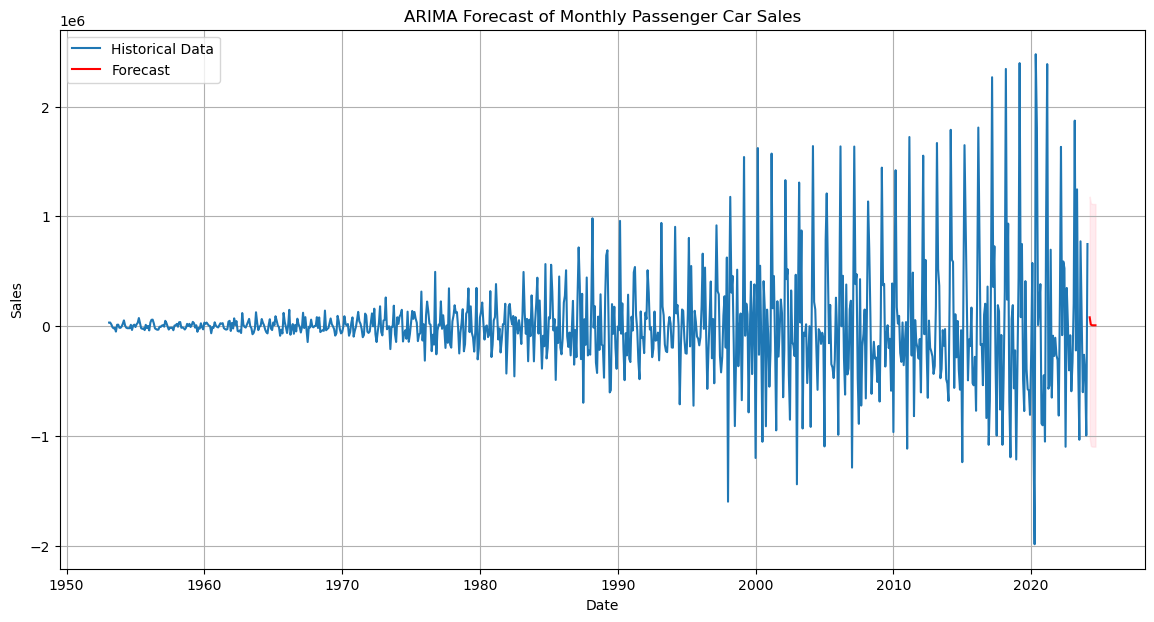

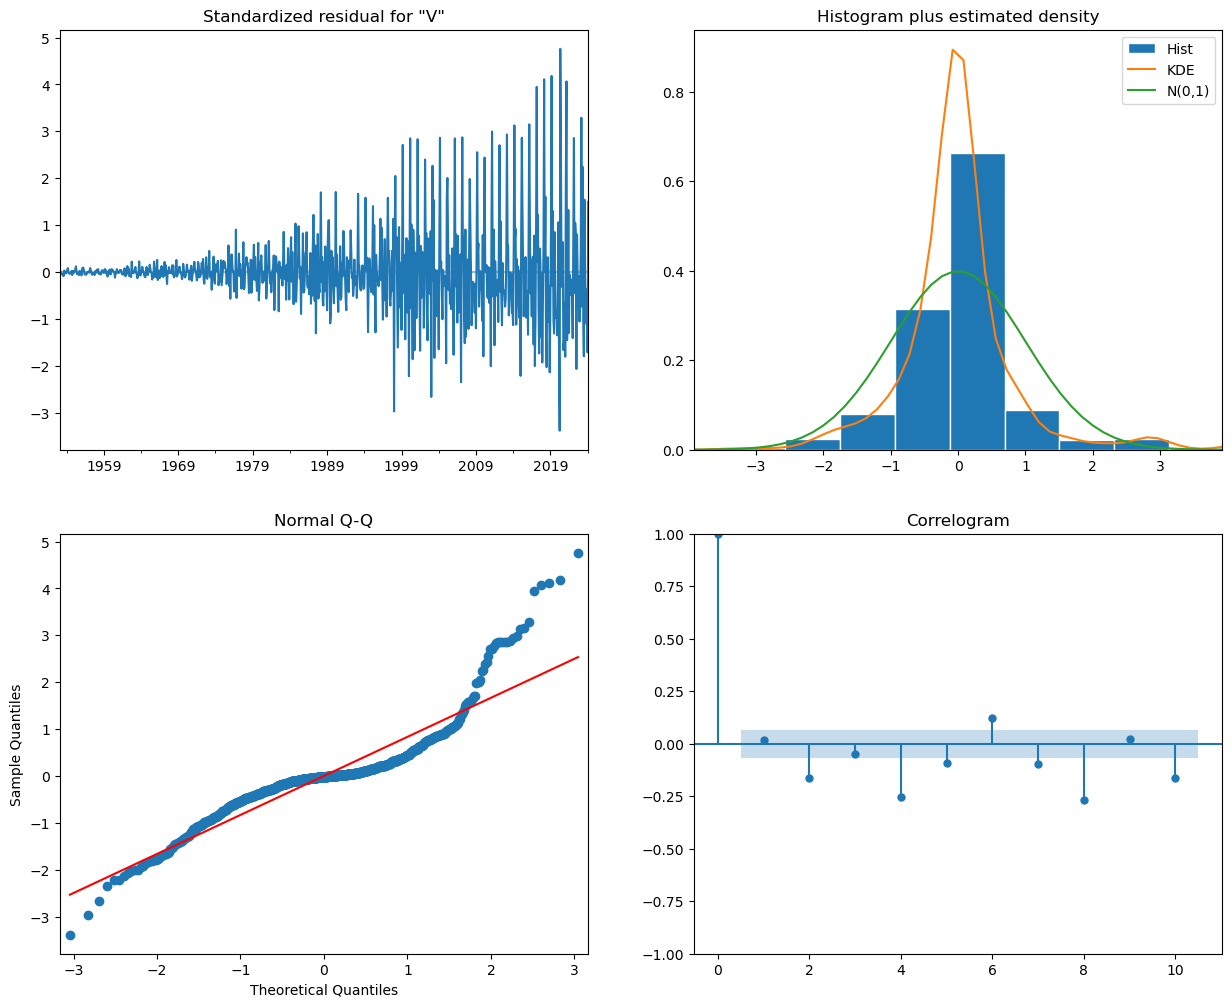

In [230]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Assuming 'df' is already defined and preprocessed as previously discussed

# Fit the ARIMA model
model = ARIMA(df['VALUE'], order=(1, 1, 1))
fitted_model = model.fit()

# Forecast next 6 months
forecast = fitted_model.get_forecast(steps=6)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Dates for the forecast
dates = pd.date_range(df.index[-1], periods=7, freq='M')[1:]

# Plot historical data
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['VALUE'], label='Historical Data')

# Plot forecast
plt.plot(dates, mean_forecast, color='red', label='Forecast')
plt.fill_between(dates, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('ARIMA Forecast of Monthly Passenger Car Sales')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Plot diagnostic plots for the ARIMA model
fitted_model.plot_diagnostics(figsize=(15, 12))
plt.show()
